## 필요한 라이브러리 import

In [292]:
import warnings
warnings.filterwarnings("ignore")
import os
from os.path import join
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression , Ridge , Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

## 데이터 전처리

In [293]:
# data load
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')   

data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [294]:
# data 중 label 분리
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [295]:
# 학습 데이터와 제출 데이터 합치기 -> 결측치, 변수 정리, column 중 정규화를 한번에 할 수 있다
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [296]:
# 결측치 확인
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [297]:
# id, date 변수 정리
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [298]:
# date 칼럼 정리
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)
data.head()

# data['date'] = data['date'].apply(lambda x : str(x[:6]))
# data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


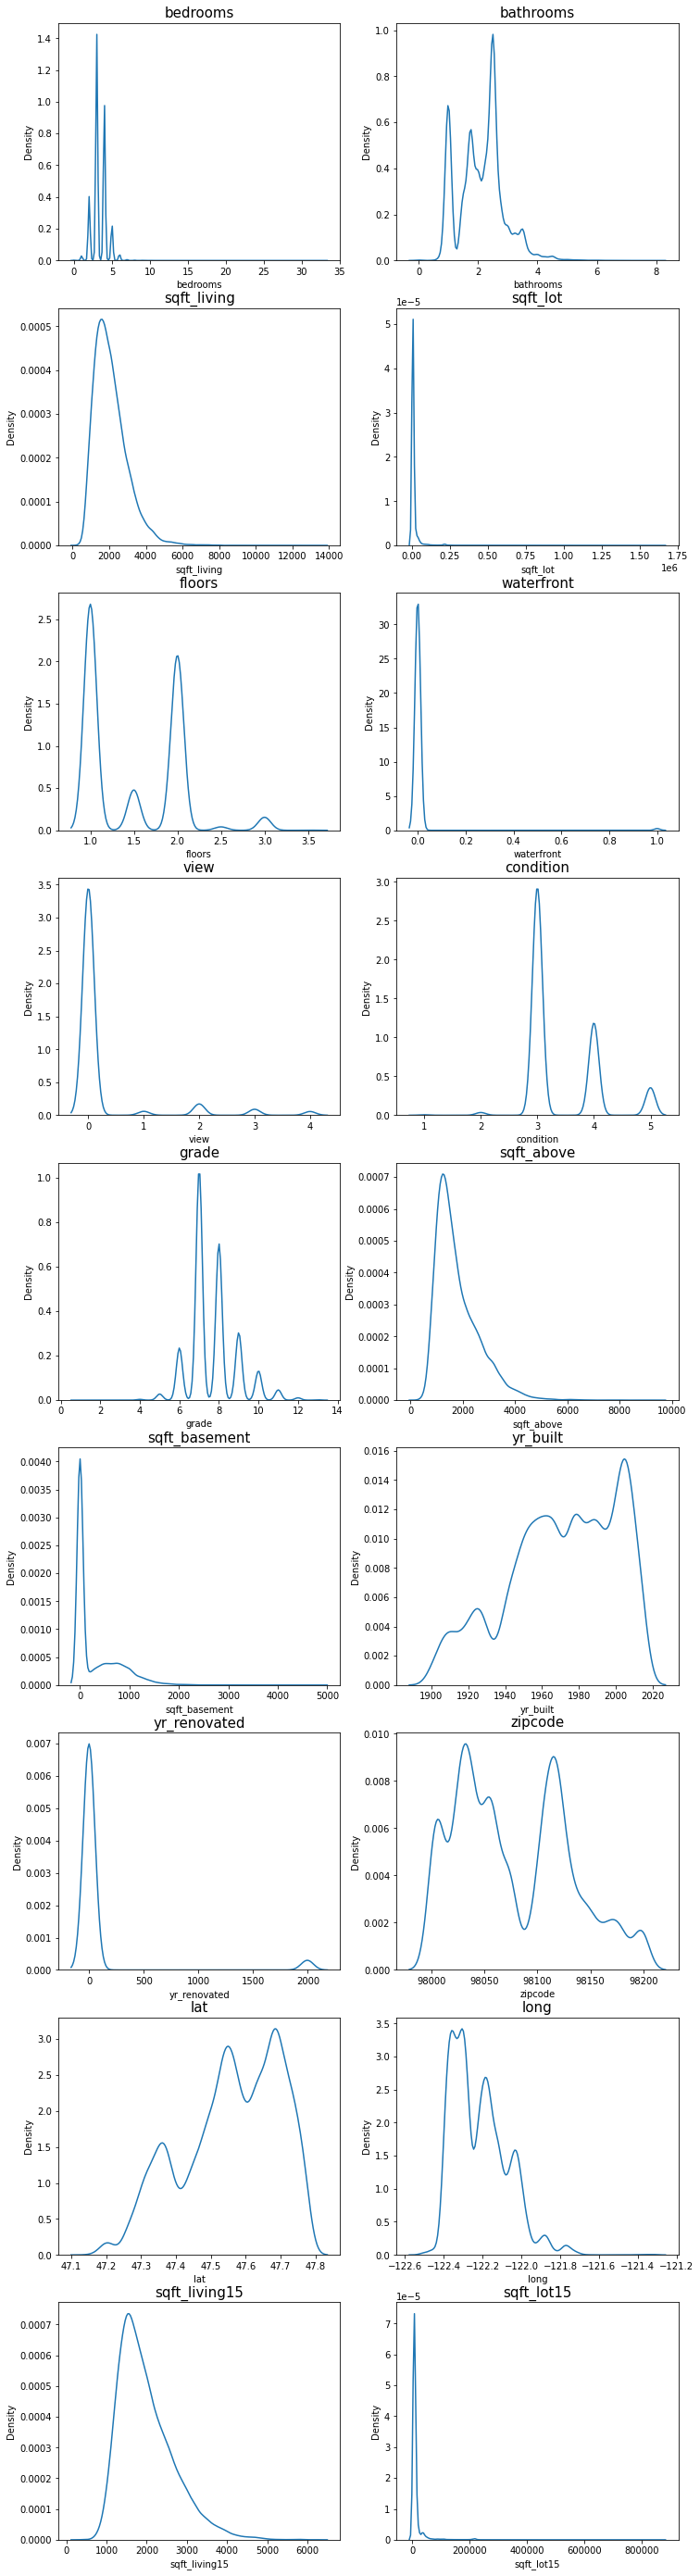

In [299]:
# 각 변수들의 분포 확인
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

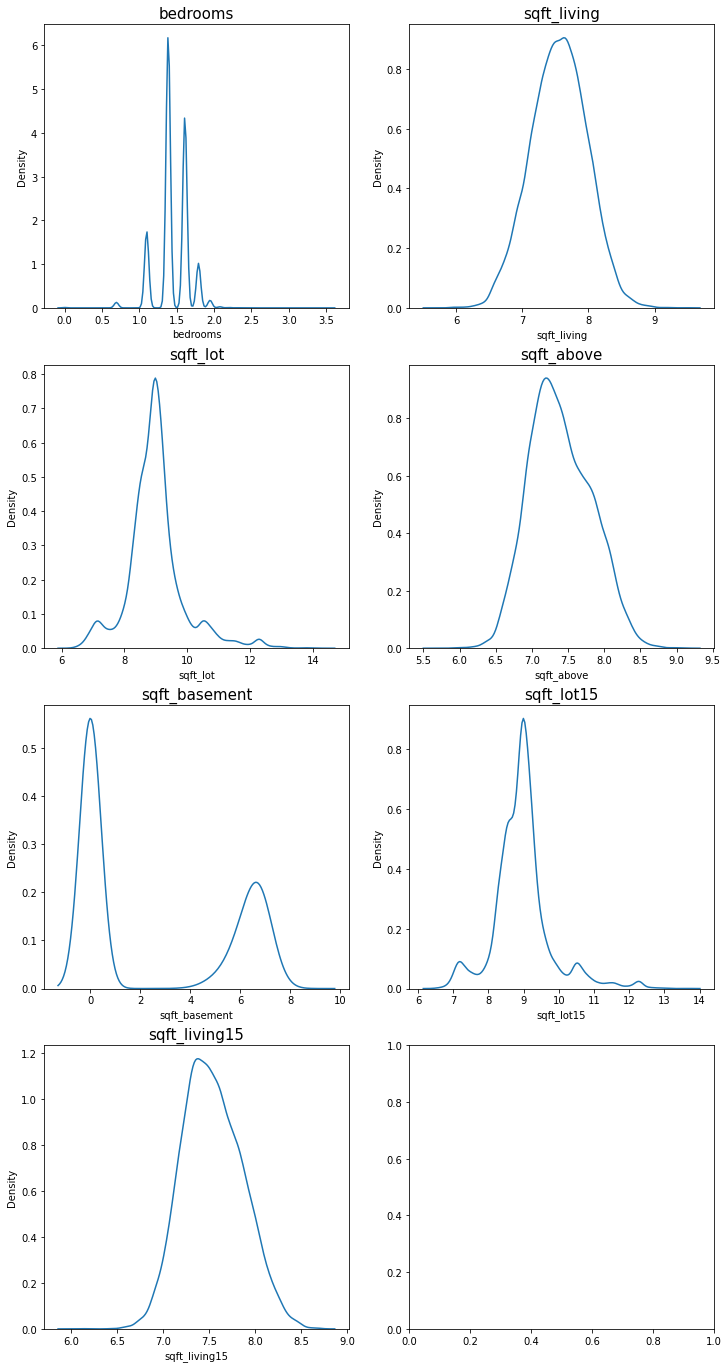

In [300]:
# features 정규화 적용
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [301]:
# target 정규화 적용
y = np.log1p(y)

In [302]:
# 학습 데이터와 제출 데이터 분리
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


# 하이퍼 파라미터 조정

## 첫 제출의 private score가 116127.87308이었기 때문에 model의 fine tunning을 통해 발전시키로 결정했다. 제시된 기준 점수와 큰 차이가 없었고, 변수들 간의 상관관계를 살피는 것보다 조금 더 효율적이라고 생각했다. 그래서 많은 시간을 투자하여 하이퍼 파라미터 조정을 했다.

In [281]:
# 모델 load
ridge = Ridge()
lasso = Lasso()
en = ElasticNet()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
gbm = GradientBoostingRegressor()
xgb = XGBRegressor()
lgbm = LGBMRegressor()

models = [ridge, lasso, en, dt, rf, gbm, xgb, lgbm]

In [282]:
# 하이퍼파라미터 후보들
ridge_params = { 'alpha':[0.001, 0.01, 0.05, 0.09, 0.1, 0.11, 0.12]}
lasso_params = { 'alpha':[0.005, 0.01, 0.015]}
en_params = { 'alpha':[0.001, 0.005, 0.01]}
dt_params = {'max_depth':[8, 9, 10]}
rf_params = {'n_estimators':[50, 100], 'max_depth' : [10, 15, 20]}
gbm_params = {'n_estimators':[50, 100], 'max_depth' : [5, 10, 15]}
xgb_params = {'n_estimators':[140, 150, 160], 'max_depth': [5]}
lgbm_params = {'n_estimators':[366], 'max_depth': [9, 10, 11]}

params = [ridge_params, lasso_params, en_params, dt_params, rf_params, gbm_params, xgb_params, lgbm_params]

여러 모델들을 이 문제의 채점기준인 RMSE 값을 기준으로 평가했을 때, RandomForestRegressor, GradientBoostingRegressor, XGBRegressor, LGBMRegressor의 성능이 좋았다. 그래서 Rige, Lasso, ElasticNet, DecisionTreeRegressor의 fine tunning는 초기 단계에 멈췄다. 

In [ ]:
rf = RandomForestRegressor()
gbm = GradientBoostingRegressor()
xgb = XGBRegressor()
lgbm = LGBMRegressor()

models = [rf, gbm, xgb, lgbm]

In [ ]:
# 하이퍼파라미터 후보들
rf_params = {'n_estimators':[50, 100], 'max_depth' : [10, 15, 20]}
gbm_params = {'n_estimators':[50, 100], 'max_depth' : [5, 10, 15]}
xgb_params = {'n_estimators':[140, 150, 160], 'max_depth': [5]}
lgbm_params = {'n_estimators':[366], 'max_depth': [9, 10, 11]}

params = [rf_params, gbm_params, xgb_params, lgbm_params]

4개로 줄인 모델들을 fine tunning 하다보니 XGBRegressor에서 긴 시간이 걸리는 문제가 있었다. 그래서 모델들을 여러가지 경우의 수로 캐글에 제출해보고 그 중 최적의 모델 조합을 선택하여 fine tunning에 집중하기로 했다. 

여러 조합들 중 XGBRegressor와 LGBMRegressor의 조합으로 할 때가 가장 효과적이었다. 따라서 XGBRegressor와 LGBMRegressor의 fine tunning에 집중했다.

In [303]:
xgb = XGBRegressor()
lgbm = LGBMRegressor()

# models = [xgb, lgbm]
models = [xgb]

In [325]:
xgb_params = {'n_estimators':[142], 'max_depth': [4]}
lgbm_params = {'n_estimators':[366], 'max_depth': [10]}

# params = [xgb_params, lgbm_params]
params = [xgb_params]

In [326]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['MSLE'] = score
    
    # RMSE 값 계산 후 정렬
    results['RMSE'] = np.sqrt(-1 * np.expm1(results['MSLE']))
    results = results.sort_values('RMSE')

    return results

In [327]:
for i in range(0, len(models)):
    print(my_GridSearch(models[i], x, y, params[i]))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed:  2.0min remaining:   52.4s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  2.0min finished


   max_depth  n_estimators      MSLE      RMSE
1          4           142 -0.028026  0.166242
0          3           142 -0.028874  0.168703


## 오랜 시간동안 fine tunning을 하여 최종적으로 최적의 하이퍼파라미터를 구했다.<br/>
xgb_params = {'n_estimators':[142], 'max_depth': [4]}<br/>
lgbm_params = {'n_estimators':[366], 'max_depth': [10]}

## Train

In [337]:
# 모델 정의
random_state = 17

# xgboost = XGBRegressor(n_estimators=142, max_depth=4, random_state=random_state)
# lightgbm = LGBMRegressor(n_estimators=366, max_depth=10, random_state=random_state)
xgboost = XGBRegressor(n_estimators=150, max_depth=5, random_state=random_state)
lightgbm = LGBMRegressor(n_estimators=366, max_depth=10, random_state=random_state)

models = [xgboost, lightgbm]

그런데 오히려 최적의 해라고 구했을 때보다 그 이전 단계의 조합에서 최상의 결과값이 나왓다. 그래서 최종 제출은 이전 단계의 조합으로 하여 제출했다.

In [338]:
# rmse 계산
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [339]:
# rmse 계산 함수
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [340]:
# 모델 평가
get_scores(models, x, y)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,RMSE
XGBRegressor,123478.059896
LGBMRegressor,121486.051853


## Submission data로 예측

In [341]:
# model 정의
models = [{'model':xgboost, 'name':'XGBoost'}, {'model':lightgbm, 'name':'LightGBM'}]

In [342]:
# 모델 예측 결과의 평균
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        np.expm1(m['model'].predict(sub_x.values)) for m in models
    ])
    return np.mean(predictions, axis=1)

In [343]:
# 예측값 생성
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6468


array([ 536773.09657814,  469163.22422207, 1326699.59072965, ...,
        465659.73583151,  328543.94688886,  466959.8718027 ])

## Submission 파일 생성

In [344]:
# 제출을 위한 dataframe 생성
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.367731e+05
1,15036,4.691632e+05
2,15037,1.326700e+06
3,15038,3.067813e+05
4,15039,3.315647e+05


In [345]:
# submission file 생성
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


## 회고
- 이번 프로젝트에서 어려웠던 점
    - 시각화 툴에 익숙하지 않아서 다양한 변수의 중요도 표현에 어려움이 있었다.
    
- 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
    - 여러 단계의 fine tunning을 통해 최적의 하이퍼파라미터를 구했을 때보다 그 과정에서의 하이퍼파라미터가 최상의 결과를 보였다.
- 자기 다짐
    - 사용할 feature를 결정하기 위해 다양한 시각화 처리를 익혀야겠다.

## 결과
private score: 109789.76487

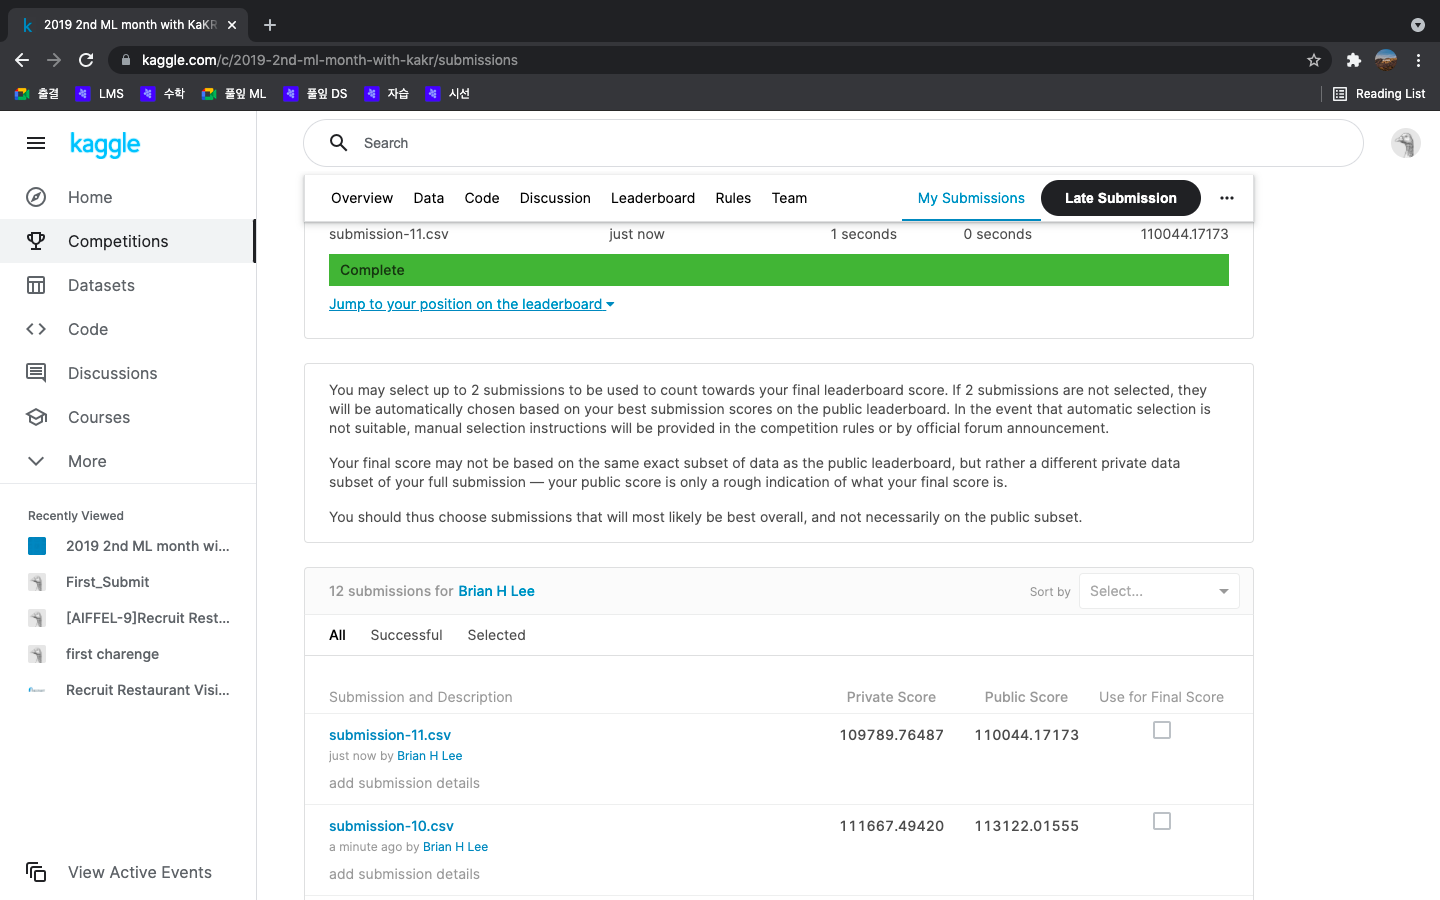